<a href="https://colab.research.google.com/github/Matheus-P/BERT-for-bug-triage/blob/main/BERT_for_bug_triage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Importando Bibliotecas

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 40.7 MB/s 
     |████████████████████████████████| 596 kB 44.7 MB/s 
     |████████████████████████████████| 895 kB 69.6 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import torch
from transformers import AutoTokenizer, DistilBertForSequenceClassification,\
                         DistilBertConfig, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,\
                            f1_score
from sklearn import preprocessing, neighbors, naive_bayes, svm,\
                    feature_extraction

In [ ]:
# Função para plot das comparações
def plot_metrics(task : str):
  models_list = ['BERT','KNN','NB','SVC']
  fig, axs = plt.subplots(1,4, sharex=True, sharey=True, figsize=(30,5))
  for p, model in enumerate(models_list):
    metrics = np.load(path+'/Metrics'+task+'/metrics_'+
                      model+'.npy',allow_pickle=True).flatten()[0]
    datasets_f1s = np.ndarray((5,10))
    for key in metrics:
      dataset, fold = int(key.split()[1]),int(key.split()[3])
      datasets_f1s[dataset][fold] = metrics[key]
    for i in range(0,5):
      axs[p].plot(datasets_f1s[i],label='dataset '+str(i))
    for ax in axs.flat:
      ax.set(xlabel='# of fold', ylabel='F1 Score')
    axs[p].set_title('F1 Scores for {}'.format(model))
    axs[p].legend()

#Dataset

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/MSR-2021'
bash_path = '/content/drive/MyDrive/Colab\ Notebooks/MSR-2021'

In [ ]:
#! unzip $bash_path/Dataset.zip -d $bash_path

In [ ]:
df_dict = {'df_eclipse':'/Dataset/Eclipse_total.csv',
           'df_gcc':'/Dataset/GCC_total.csv',
           'df_mozilla':'/Dataset/Mozilla_total.csv',
           'df_netbeans':'/Dataset/Netbeans_total.csv',
           'df_openoffice':'/Dataset/OpenOffice_total.csv'}

In [ ]:
# Loading csv to dataframe, ignore 'status' column because it has only one
# distinct value, use 'Bug_report_ID' as index
columns = ['Bug_report_ID','Product_Name','summary','description',
           'component_name','severity_level','priority',
           'assignee_developers','topic_id']

In [ ]:
for key in df_dict.keys():
  exec("{} = pd.read_csv(path+df_dict['{}'],\
        index_col='Bug_report_ID',usecols=columns)".format(key,key))

In [ ]:
df_list = [df_eclipse, df_gcc, df_mozilla, df_netbeans, df_openoffice]

In [ ]:
severities = ['blocker','critical','major','minor','trivial']
columns_to_be_dropped = ['Product_Name','summary','description',
                         'component_name','priority','topic_id']

In [ ]:
def df_cleanup(df: pd.DataFrame):
  # Remove normal, enhancement, and other severities
  idx = df.index[~df['severity_level'].isin(severities)]
  df.drop(index=idx,inplace=True)

  # Create two columns representing the entire report, without the target column
  df['FullReportDetails_withoutSeverity'] = df['Product_Name']+' '+df['summary']+' '+df['description']+' '+df['component_name']+' '+df['priority']+' '+df['assignee_developers']
  df['FullReportDetails_withoutAssigned'] = df['Product_Name']+' '+df['summary']+' '+df['description']+' '+df['component_name']+' '+df['severity_level']+' '+df['priority']

  # Drop columns already used in the above step
  df.drop(columns=columns_to_be_dropped,inplace=True)
  df.dropna(inplace=True)

  # Set index as integer type and sort in ascending order
  df.reset_index(inplace=True)
  df['Bug_report_ID'] = df['Bug_report_ID'].astype(int)
  df.set_index('Bug_report_ID',inplace=True)
  df.sort_index(inplace=True)

  # Encode target columns
  le = preprocessing.LabelEncoder()
  le.fit(df['severity_level'])
  df['severity_level'] = le.transform(df['severity_level'])
  
  le = preprocessing.LabelEncoder()
  le.fit(df['assignee_developers'])
  df['assignee_developers'] = le.transform(df['assignee_developers'])

In [ ]:
dfs_list = [df.pipe(df_cleanup) for df in df_list]

In [ ]:
def df_split(df: pd.DataFrame):
  split_size = len(df)//11
  split_remainder = len(df)%11
  return [df[0:split_size],
          df[split_size:split_size*2],
          df[split_size*2:split_size*3],
          df[split_size*3:split_size*4],
          df[split_size*4:split_size*5],
          df[split_size*5:split_size*6],
          df[split_size*6:split_size*7],
          df[split_size*7:split_size*8],
          df[split_size*8:split_size*9],
          df[split_size*9:split_size*10],
          df[split_size*10:split_size*11+split_remainder]]

In [ ]:
# Acess: 
# split_df_list[i] == list of 11 splits for the ith DataFrame(Dataset)
# split_df_list[i][j] == jth split of the ith DataFrame(Dataset)
split_df_list = [df.pipe(df_split) for df in df_list]

#Modelo 1: Predição de Severidade

##BERT

In [ ]:
class DatasetForSeverityPrediction(torch.utils.data.Dataset):

    def __init__(self, report, severity, tokenizer):
        self.report     = report
        self.severity   = severity
        self.tokenizer  = tokenizer
        self.max_len    = tokenizer.model_max_length
  
    def __len__(self):
        return len(self.report)
  
    def __getitem__(self, index):
        report = self.report[index]
        severity = self.severity[index]

        encoded_report = self.tokenizer.encode_plus(
            report,
            add_special_tokens    = True,
            max_length            = self.max_len,
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors        = "pt",
            padding               = "max_length",
            truncation            = True
        )

        return {
            'input_ids': encoded_report['input_ids'][0],
            'attention_mask': encoded_report['attention_mask'][0],
            'labels': torch.tensor(severity, dtype=torch.long)
        }


# Returns one of the 5 Datasets
def get_dataset(dataset):
  train_datasets = []
  test_datasets = []

  for i in range(1,11):
    test_set = split_df_list[dataset][i]
    train_set = pd.concat(split_df_list[dataset][i] for i in range(0,i))
    
    train_datasets.append(
      DatasetForSeverityPrediction(
        report     = train_set.FullReportDetails_withoutSeverity.tolist(),
        severity   = train_set.severity_level.tolist(),
        tokenizer  = tokenizer
      )
    )

    test_datasets.append(
      DatasetForSeverityPrediction(
        report     = test_set.FullReportDetails_withoutSeverity.tolist(),
        severity   = test_set.severity_level.tolist(),
        tokenizer  = tokenizer
      )
    )

  return train_datasets, test_datasets

# Returns evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds,
                                                               average='micro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Training loop
def train_eval(model, dataset: int, fold: int):
  train_datasets, test_datasets = get_dataset(dataset)

  training_args = TrainingArguments(
      output_dir                  = path+"/severity-report-checkpoints"+str(dataset),
      overwrite_output_dir        = True,
      num_train_epochs            = 1,
      per_device_train_batch_size = 16,
      per_device_eval_batch_size  = 16,
      warmup_steps                = 500,
      weight_decay                = 0.01,
      save_strategy               = "epoch",
      evaluation_strategy         = "steps",
      do_predict = True
  )

  trainer = Trainer(
      model           = model,
      args            = training_args,
      train_dataset   = train_datasets[fold],
      eval_dataset    = test_datasets[fold],
      compute_metrics = compute_metrics
  )

  trainer.train()
  return trainer.predict(test_datasets[fold])[2]['test_f1']

def get_metrics_from_checkpoint():
  tmp = np.load(path+'/MetricsSeverityPrediction/metrics_BERT.npy',allow_pickle=True)
  tmp = dict(enumerate(tmp.flatten()))[0]
  return tmp

In [ ]:
# Define the Base Model Checkpoint
checkpoint = 'distilbert-base-uncased'
# Load the model configs only, we need to change the number of classes
configs = DistilBertConfig.from_pretrained(checkpoint, num_labels=5)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
try:
    metrics_BERT = get_metrics_from_checkpoint()
    initial_k = int(list(metrics_BERT.keys())[-1].split()[1])
    initial_i = int(list(metrics_BERT.keys())[-1].split()[3])
except FileNotFoundError:
    metrics_BERT = {}
    initial_k = 0
    initial_i = 0

for k in range(initial_k,5):
  # Load the tokenizer for the DistilBERT model.
  tokenizer = AutoTokenizer.from_pretrained(checkpoint)
  # Create the model with the loaded configs
  model = DistilBertForSequenceClassification(config=configs)
  print('----------------------- Dataset '+str(k)+': -----------------------')
  for i in range(initial_i,10):
    metrics_BERT['dataset '+str(k)+' fold '+str(i)+' f1:'] = train_eval(model, k, i)
    np.save(path+'/MetricsSeverityPrediction/metrics_BERT.npy',metrics_BERT)

In [ ]:
metrics_BERT

##Baseline

In [ ]:
def get_baseline_dataset(dataset):
  vectorizer = feature_extraction.text.TfidfVectorizer()
  baseline_train_datasets = []
  baseline_test_datasets = []

  for i in range(1,11):
    baseline_test_set = split_df_list[dataset][i]
    baseline_train_set = pd.concat(split_df_list[dataset][i] for i in range(0,i))

    sample = vectorizer.fit_transform(baseline_test_set['FullReportDetails_withoutSeverity'])
    target = baseline_test_set['severity_level']
    baseline_test_datasets.append((sample,target))

    sample = vectorizer.transform(baseline_train_set['FullReportDetails_withoutSeverity'])
    target = baseline_train_set['severity_level']
    baseline_train_datasets.append((sample,target))

  return list(zip(baseline_train_datasets, baseline_test_datasets))

def baseline_eval(classifier):
  metrics = {}
  for k in range(0,5):
    datasets = get_baseline_dataset(k)
    for i in range(0,10):
        classifier.fit(datasets[i][0][0],datasets[i][0][1])
        preds = classifier.predict(datasets[i][1][0])
        metrics['dataset '+str(k)+' fold '+str(i)+' f1:'] = f1_score(datasets[i][1][1], preds,
                                              average='micro')
  return metrics

###KNeighborsClassifier

In [ ]:
classifier = neighbors.KNeighborsClassifier()
metrics_KNN = baseline_eval(classifier)
metrics_KNN

{'dataset 0 fold 0 f1:': 0.3805970149253731,
 'dataset 0 fold 1 f1:': 0.3417910447761194,
 'dataset 0 fold 2 f1:': 0.41044776119402987,
 'dataset 0 fold 3 f1:': 0.4462686567164179,
 'dataset 0 fold 4 f1:': 0.3641791044776119,
 'dataset 0 fold 5 f1:': 0.3597014925373134,
 'dataset 0 fold 6 f1:': 0.3656716417910448,
 'dataset 0 fold 7 f1:': 0.3522388059701492,
 'dataset 0 fold 8 f1:': 0.3611940298507462,
 'dataset 0 fold 9 f1:': 0.3514705882352941,
 'dataset 1 fold 0 f1:': 0.9959839357429718,
 'dataset 1 fold 1 f1:': 0.9759036144578314,
 'dataset 1 fold 2 f1:': 0.9076305220883534,
 'dataset 1 fold 3 f1:': 0.8112449799196787,
 'dataset 1 fold 4 f1:': 0.751004016064257,
 'dataset 1 fold 5 f1:': 0.5863453815261044,
 'dataset 1 fold 6 f1:': 0.321285140562249,
 'dataset 1 fold 7 f1:': 0.1686746987951807,
 'dataset 1 fold 8 f1:': 0.2248995983935743,
 'dataset 1 fold 9 f1:': 0.2071713147410359,
 'dataset 2 fold 0 f1:': 0.36820083682008364,
 'dataset 2 fold 1 f1:': 0.3723849372384937,
 'dataset 

###MultinomialNB

In [ ]:
classifier = naive_bayes.MultinomialNB()
metrics_NB = baseline_eval(classifier)
metrics_NB

{'dataset 0 fold 0 f1:': 0.3656716417910448,
 'dataset 0 fold 1 f1:': 0.4164179104477612,
 'dataset 0 fold 2 f1:': 0.49850746268656715,
 'dataset 0 fold 3 f1:': 0.46865671641791046,
 'dataset 0 fold 4 f1:': 0.44477611940298506,
 'dataset 0 fold 5 f1:': 0.42985074626865666,
 'dataset 0 fold 6 f1:': 0.3761194029850746,
 'dataset 0 fold 7 f1:': 0.4164179104477612,
 'dataset 0 fold 8 f1:': 0.4208955223880597,
 'dataset 0 fold 9 f1:': 0.4279411764705882,
 'dataset 1 fold 0 f1:': 0.9959839357429718,
 'dataset 1 fold 1 f1:': 0.9718875502008032,
 'dataset 1 fold 2 f1:': 0.9076305220883534,
 'dataset 1 fold 3 f1:': 0.8112449799196787,
 'dataset 1 fold 4 f1:': 0.7550200803212851,
 'dataset 1 fold 5 f1:': 0.5502008032128514,
 'dataset 1 fold 6 f1:': 0.2971887550200803,
 'dataset 1 fold 7 f1:': 0.14056224899598393,
 'dataset 1 fold 8 f1:': 0.1606425702811245,
 'dataset 1 fold 9 f1:': 0.16733067729083664,
 'dataset 2 fold 0 f1:': 0.32217573221757323,
 'dataset 2 fold 1 f1:': 0.42677824267782427,
 '

###SVC

In [ ]:
classifier = svm.SVC()
metrics_SVC = baseline_eval(classifier)
metrics_SVC

{'dataset 0 fold 0 f1:': 0.41492537313432837,
 'dataset 0 fold 1 f1:': 0.4417910447761194,
 'dataset 0 fold 2 f1:': 0.5671641791044776,
 'dataset 0 fold 3 f1:': 0.5208955223880597,
 'dataset 0 fold 4 f1:': 0.4835820895522388,
 'dataset 0 fold 5 f1:': 0.4671641791044776,
 'dataset 0 fold 6 f1:': 0.4388059701492537,
 'dataset 0 fold 7 f1:': 0.4791044776119403,
 'dataset 0 fold 8 f1:': 0.46567164179104475,
 'dataset 0 fold 9 f1:': 0.40147058823529413,
 'dataset 1 fold 0 f1:': 0.9959839357429718,
 'dataset 1 fold 1 f1:': 0.9759036144578314,
 'dataset 1 fold 2 f1:': 0.9076305220883534,
 'dataset 1 fold 3 f1:': 0.8112449799196787,
 'dataset 1 fold 4 f1:': 0.7550200803212851,
 'dataset 1 fold 5 f1:': 0.5622489959839357,
 'dataset 1 fold 6 f1:': 0.30120481927710846,
 'dataset 1 fold 7 f1:': 0.17269076305220885,
 'dataset 1 fold 8 f1:': 0.25301204819277107,
 'dataset 1 fold 9 f1:': 0.17928286852589642,
 'dataset 2 fold 0 f1:': 0.33472803347280333,
 'dataset 2 fold 1 f1:': 0.4476987447698745,
 '

###Saving

In [ ]:
np.save(path+'/MetricsSeverityPrediction/metrics_KNN.npy',metrics_KNN)
np.save(path+'/MetricsSeverityPrediction/metrics_NB.npy',metrics_NB)
np.save(path+'/MetricsSeverityPrediction/metrics_SVC.npy',metrics_SVC)

## Comparação

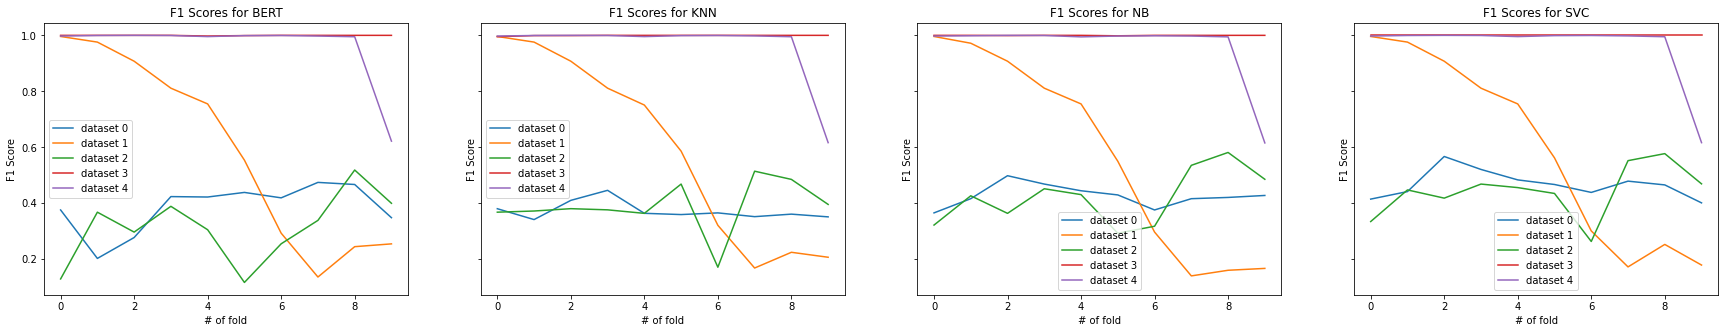

In [ ]:
plot_metrics('SeverityPrediction')

#Modelo 2: Fixer Recommendation

##BERT

In [ ]:
class DatasetForBugTriage(torch.utils.data.Dataset):

    def __init__(self, report, assigned, tokenizer):
        self.report     = report
        self.assigned   = assigned
        self.tokenizer  = tokenizer
        self.max_len    = tokenizer.model_max_length
  
    def __len__(self):
        return len(self.report)
  
    def __getitem__(self, index):
        report = self.report[index]
        assigned = self.assigned[index]

        encoded_report = self.tokenizer.encode_plus(
            report,
            add_special_tokens    = True,
            max_length            = self.max_len,
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors        = "pt",
            padding               = "max_length",
            truncation            = True
        )

        return {
            'input_ids': encoded_report['input_ids'][0],
            'attention_mask': encoded_report['attention_mask'][0],
            'labels': torch.tensor(assigned, dtype=torch.long)
        }


# Returns one of the 5 Datasets
def get_dataset(dataset):
  train_datasets = []
  test_datasets = []

  for i in range(1,11):
    test_set = split_df_list[dataset][i]
    train_set = pd.concat(split_df_list[dataset][i] for i in range(0,i))
    
    train_datasets.append(
      DatasetForBugTriage(
        report     = train_set.FullReportDetails_withoutAssigned.tolist(),
        assigned   = train_set.assignee_developers.tolist(),
        tokenizer  = tokenizer
      )
    )

    test_datasets.append(
      DatasetForBugTriage(
        report     = test_set.FullReportDetails_withoutAssigned.tolist(),
        assigned   = test_set.assignee_developers.tolist(),
        tokenizer  = tokenizer
      )
    )

  return train_datasets, test_datasets

# Returns evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds,
                                                               average='micro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Training loop
def train_eval(model, dataset: int, fold: int):
  train_datasets, test_datasets = get_dataset(dataset)

  training_args = TrainingArguments(
      output_dir                  = path+"/bug-triage-checkpoints"+str(dataset),
      overwrite_output_dir        = True,
      num_train_epochs            = 1,
      per_device_train_batch_size = 16,
      per_device_eval_batch_size  = 16,
      warmup_steps                = 500,
      weight_decay                = 0.01,
      save_strategy               = "epoch",
      evaluation_strategy         = "steps",
      do_predict = True
  )

  trainer = Trainer(
      model           = model,
      args            = training_args,
      train_dataset   = train_datasets[fold],
      eval_dataset    = test_datasets[fold],
      compute_metrics = compute_metrics
  )

  trainer.train()
  return trainer.predict(test_datasets[fold])[2]['test_f1']

def get_metrics_from_checkpoint():
  tmp = np.load(path+'/MetricsBugTriage/metrics_BERT.npy',allow_pickle=True)
  tmp = dict(enumerate(tmp.flatten()))[0]
  return tmp

In [ ]:
# Define the Base Model Checkpoint
checkpoint = 'distilbert-base-uncased'
# Load the model configs only, we need to change the number of classes
configs = DistilBertConfig.from_pretrained(checkpoint, num_labels=532)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
try:
    metrics_BERT = get_metrics_from_checkpoint()
    initial_k = int(list(metrics_BERT.keys())[-1].split()[1])
    initial_i = int(list(metrics_BERT.keys())[-1].split()[3])
except FileNotFoundError:
    metrics_BERT = {}
    initial_k = 0
    initial_i = 0

for k in range(initial_k,5):
  # Load the tokenizer for the DistilBERT model.
  tokenizer = AutoTokenizer.from_pretrained(checkpoint)
  # Create the model with the loaded configs
  model = DistilBertForSequenceClassification(config=configs)
  print('----------------------- Dataset '+str(k)+': -----------------------')
  for i in range(initial_i,10):
    metrics_BERT['dataset '+str(k)+' fold '+str(i)+' f1:'] = train_eval(model, k, i)
    np.save(path+'/MetricsBugTriage/metrics_BERT.npy',metrics_BERT)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

----------------------- Dataset 0: -----------------------


***** Running training *****
  Num examples = 670
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-42
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-42/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-42/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 670
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 1340
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 84


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-84
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-84/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-84/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 670
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 2010
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 126


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-126
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-126/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-126/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 670
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 2680
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 168


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-168
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-168/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-168/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 670
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 3350
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 210


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-210
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-210/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-210/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 670
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 4020
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 252


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-252
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-252/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-252/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 670
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 4690
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 294


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-294
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-294/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-294/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 670
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 5360
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 335


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-335
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-335/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-335/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 670
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 6030
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 377


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-377
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-377/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-377/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 670
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 6700
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 419


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-419
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-419/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints0/checkpoint-419/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 680
  Batch size = 16


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.12.0",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebf

----------------------- Dataset 1: -----------------------


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-16
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-16/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-16/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 249
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 498
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-32
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-32/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-32/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 249
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 747
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-47
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-47/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-47/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 249
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 996
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-63
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-63/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-63/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 249
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 1245
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 78


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-78
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-78/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-78/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 249
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 1494
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 94


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-94
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-94/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-94/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 249
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 1743
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 109


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-109
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-109/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-109/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 249
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 1992
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 125


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-125
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-125/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-125/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 249
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 2241
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 141


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-141
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-141/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-141/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 249
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 2490
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 156


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-156
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-156/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints1/checkpoint-156/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 251
  Batch size = 16


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.12.0",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebf

----------------------- Dataset 2: -----------------------


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-15
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-15/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-15/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 239
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 478
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-30
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-30/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-30/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 239
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 717
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-45
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-45/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-45/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 239
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 956
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 60


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-60
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-60/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-60/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 239
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 1195
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-75
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-75/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-75/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 239
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 1434
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 90


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-90
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-90/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-90/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 239
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 1673
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 105


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-105
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-105/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-105/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 239
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 1912
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 120


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-120
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-120/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-120/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 239
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 2151
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 135


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-135
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-135/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-135/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 239
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 2390
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-150
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-150/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints2/checkpoint-150/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 245
  Batch size = 16


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.12.0",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebf

----------------------- Dataset 3: -----------------------


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-79
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-79/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-79/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1258
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 2516
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 158


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-158
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-158/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-158/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1258
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 3774
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 236


Step,Training Loss,Validation Loss


In [ ]:
try:
    metrics_BERT = get_metrics_from_checkpoint()
    initial_k = int(list(metrics_BERT.keys())[-1].split()[1])
    initial_i = int(list(metrics_BERT.keys())[-1].split()[3])
except FileNotFoundError:
    metrics_BERT = {}
    initial_k = 0
    initial_i = 0

for k in range(initial_k,5):
  # Load the tokenizer for the DistilBERT model.
  tokenizer = AutoTokenizer.from_pretrained(checkpoint)
  # Create the model with the loaded configs
  model = DistilBertForSequenceClassification(config=configs)
  print('----------------------- Dataset '+str(k)+': -----------------------')
  for i in range(initial_i,10):
    metrics_BERT['dataset '+str(k)+' fold '+str(i)+' f1:'] = train_eval(model, k, i)
    np.save(path+'/MetricsBugTriage/metrics_BERT.npy',metrics_BERT)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

----------------------- Dataset 3: -----------------------


***** Running training *****
  Num examples = 2516
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 158


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-158
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-158/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-158/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1258
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 3774
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 236


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-236
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-236/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-236/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1258
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 5032
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 315


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-315
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-315/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-315/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1258
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 6290
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 394


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-394
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-394/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-394/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1258
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 7548
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 472


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-472
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-472/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-472/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1258
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 8806
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 551


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,2.122500,2.881876,0.282194,0.282194,0.282194,0.282194


***** Running Evaluation *****
  Num examples = 1258
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-551
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-551/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-551/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1258
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 10064
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 629


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,1.960900,3.507504,0.289348,0.289348,0.289348,0.289348


***** Running Evaluation *****
  Num examples = 1258
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-629
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-629/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-629/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1258
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 11322
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 708


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,1.873900,3.764534,0.234499,0.234499,0.234499,0.234499


***** Running Evaluation *****
  Num examples = 1258
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-708
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-708/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-708/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1258
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 12580
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 787


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,1.810100,3.620927,0.281869,0.281869,0.281869,0.281869


***** Running Evaluation *****
  Num examples = 1263
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-787
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-787/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints3/checkpoint-787/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1263
  Batch size = 16


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.12.0",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebf

----------------------- Dataset 4: -----------------------


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-255
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-255/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-255/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 2036
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 6108
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 382


Step,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-382
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-382/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-382/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 2036
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 8144
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 509


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,3.108000,3.398812,0.311886,0.311886,0.311886,0.311886


***** Running Evaluation *****
  Num examples = 2036
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-509
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-509/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-509/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 2036
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 10180
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 637


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,2.856400,3.303832,0.389980,0.389980,0.389980,0.389980


***** Running Evaluation *****
  Num examples = 2036
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-637
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-637/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-637/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 2036
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 12216
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 764


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,2.655700,3.159354,0.396365,0.396365,0.396365,0.396365


***** Running Evaluation *****
  Num examples = 2036
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-764
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-764/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-764/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 2036
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 14252
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 891


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,2.496400,3.765707,0.316306,0.316306,0.316306,0.316306


***** Running Evaluation *****
  Num examples = 2036
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-891
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-891/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-891/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 2036
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 16288
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1018


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,2.447700,3.847940,0.262279,0.262279,0.262279,0.262279
1000,2.458600,3.734704,0.272102,0.272102,0.272102,0.272102


***** Running Evaluation *****
  Num examples = 2036
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2036
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-1018
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-1018/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-1018/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 2036
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 18324
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1146


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,2.383400,4.131510,0.251965,0.251965,0.251965,0.251965
1000,2.426000,3.776017,0.293222,0.293222,0.293222,0.293222


***** Running Evaluation *****
  Num examples = 2036
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2036
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-1146
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-1146/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-1146/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 2036
  Batch size = 16


using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 20360
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1273


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,2.308600,4.681587,0.225428,0.225428,0.225428,0.225428
1000,2.371900,4.945846,0.218582,0.218582,0.218582,0.218582


***** Running Evaluation *****
  Num examples = 2045
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2045
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-1273
Configuration saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-1273/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/MSR-2021/bug-triage-checkpoints4/checkpoint-1273/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 2045
  Batch size = 16


In [ ]:
metrics_BERT

{'dataset 0 fold 0 f1:': 0.034328358208955224,
 'dataset 0 fold 1 f1:': 0.050746268656716415,
 'dataset 0 fold 2 f1:': 0.025373134328358207,
 'dataset 0 fold 3 f1:': 0.025373134328358207,
 'dataset 0 fold 4 f1:': 0.025373134328358207,
 'dataset 0 fold 5 f1:': 0.08208955223880597,
 'dataset 0 fold 6 f1:': 0.09253731343283582,
 'dataset 0 fold 7 f1:': 0.09850746268656717,
 'dataset 0 fold 8 f1:': 0.2716417910447761,
 'dataset 0 fold 9 f1:': 0.2279411764705882,
 'dataset 1 fold 0 f1:': 0.0,
 'dataset 1 fold 1 f1:': 0.6706827309236948,
 'dataset 1 fold 2 f1:': 0.5823293172690763,
 'dataset 1 fold 3 f1:': 0.41767068273092367,
 'dataset 1 fold 4 f1:': 0.4859437751004016,
 'dataset 1 fold 5 f1:': 0.4738955823293173,
 'dataset 1 fold 6 f1:': 0.4136546184738956,
 'dataset 1 fold 7 f1:': 0.5180722891566265,
 'dataset 1 fold 8 f1:': 0.5461847389558233,
 'dataset 1 fold 9 f1:': 0.5338645418326693,
 'dataset 2 fold 0 f1:': 0.0,
 'dataset 2 fold 1 f1:': 0.0,
 'dataset 2 fold 2 f1:': 0.01673640167364

##Baseline

In [ ]:
def get_baseline_dataset(dataset):
  vectorizer = feature_extraction.text.TfidfVectorizer()
  baseline_train_datasets = []
  baseline_test_datasets = []

  for i in range(1,11):
    baseline_test_set = split_df_list[dataset][i]
    baseline_train_set = pd.concat(split_df_list[dataset][i] for i in range(0,i))

    sample = vectorizer.fit_transform(baseline_test_set['FullReportDetails_withoutAssigned'])
    target = baseline_test_set['assignee_developers']
    baseline_test_datasets.append((sample,target))

    sample = vectorizer.transform(baseline_train_set['FullReportDetails_withoutAssigned'])
    target = baseline_train_set['assignee_developers']
    baseline_train_datasets.append((sample,target))

  return list(zip(baseline_train_datasets, baseline_test_datasets))

def baseline_eval(classifier):
  metrics = {}
  for k in range(0,5):
    datasets = get_baseline_dataset(k)
    for i in range(0,10):
        classifier.fit(datasets[i][0][0],datasets[i][0][1])
        preds = classifier.predict(datasets[i][1][0])
        metrics['dataset '+str(k)+' fold '+str(i)+' f1:'] = f1_score(datasets[i][1][1], preds,
                                              average='micro')
  return metrics

###KNeighborsClassifier

In [ ]:
classifier = neighbors.KNeighborsClassifier()
metrics_KNN = baseline_eval(classifier)
metrics_KNN

###MultinomialNB

In [ ]:
classifier = naive_bayes.MultinomialNB()
metrics_NB = baseline_eval(classifier)
metrics_NB

###SVC

In [ ]:
classifier = svm.SVC()
metrics_SVC = baseline_eval(classifier)
metrics_SVC

###Saving

In [ ]:
np.save(path+'/MetricsBugTriage/metrics_KNN.npy',metrics_KNN)
np.save(path+'/MetricsBugTriage/metrics_NB.npy',metrics_NB)
np.save(path+'/MetricsBugTriage/metrics_SVC.npy',metrics_SVC)

## Comparação

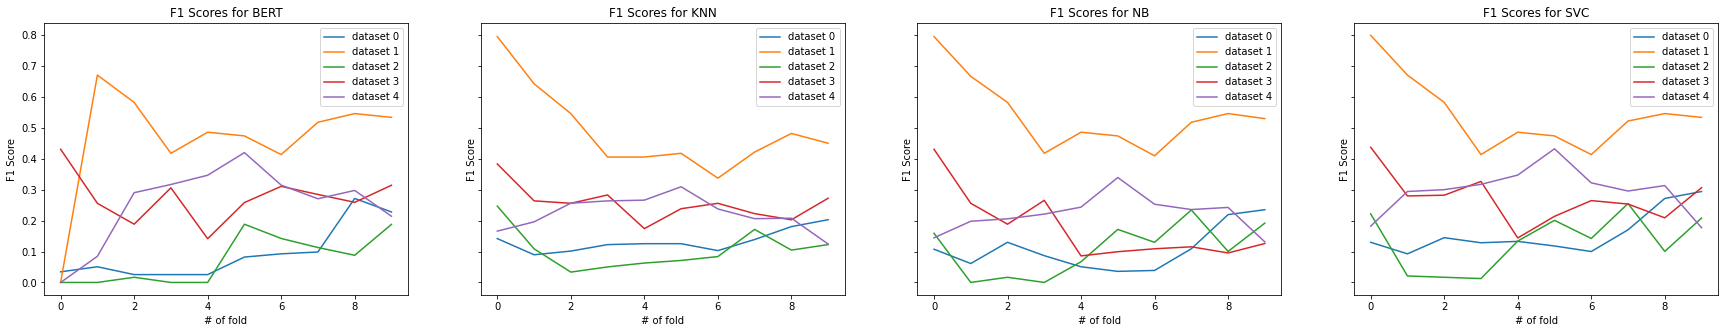

In [ ]:
plot_metrics('BugTriage')